In [1]:
import pandas as pd

from tqdm import tqdm
from xml.etree import ElementTree as ET
from networkx import Graph, DiGraph
import numpy as np
# import glasbey
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from pathlib import Path

In [46]:
track_path = Path(r"D:\FeedbackControl\data\results\tracks")
savepath = Path(r"G:\.shortcut-targets-by-id\1mjQpOyIBmhwFST1jB0FWKJhKOiVOMeb8\2025-03-24 Harrison feedback control\figure 2")
import matplotlib as mpl
mpl.rc("axes", facecolor="#ffffff00", grid=False, edgecolor="k", labelcolor="k")
mpl.rc("figure", facecolor="#00000000", dpi=100)
mpl.rc("axes.spines", top=False, right=False, )
mpl.rc("xtick", color="k", bottom=True)
mpl.rc("ytick", color="k", left=True)
mpl.rc("legend", fontsize="small")
# src = r"bar0p15.1_channel_545_tracks.csv"
# spots_df = pd.read_csv(track_path / src)

0.0
0.0
0.1
0.1
0.1
0.2
0.2
0.2
0.2
0.2
0.3
0.3
0.3
0.4
0.4
0.4
0.4
0.5
0.5
0.5
0.66
0.66
0.66
0.83
0.83
0.83


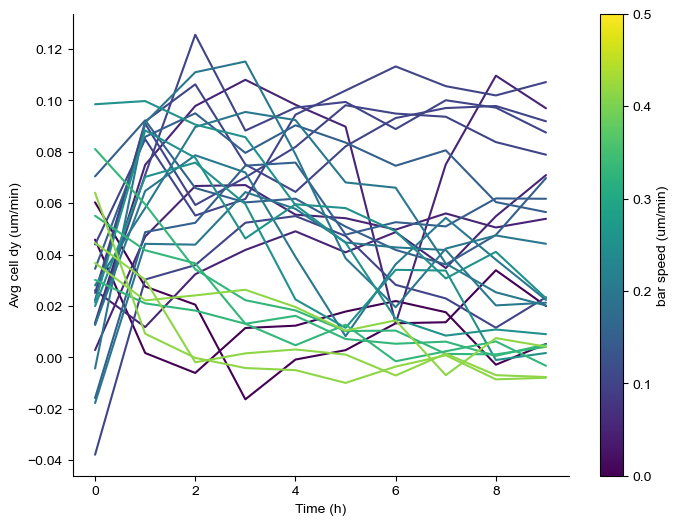

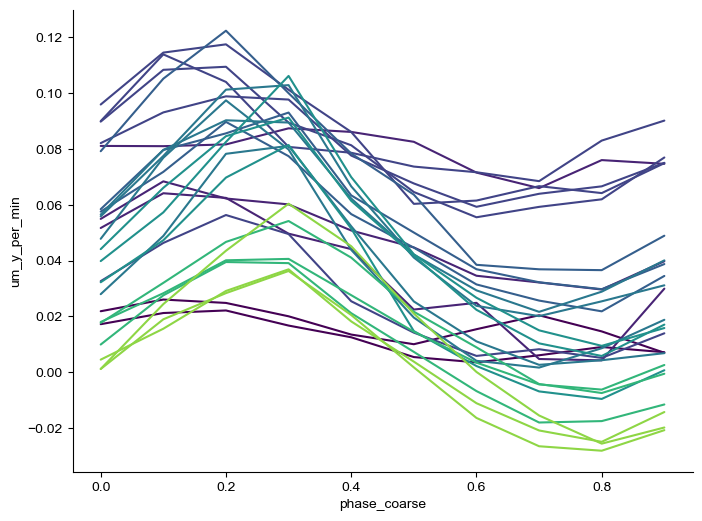

In [243]:
import matplotlib as mpl
from collections import defaultdict


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
# ax.set_ylim(0, 0.5)

# experiments = {
#     "bar_speed": [],
#     "avg_speed": [],
#     "median_speed": [],
#     "top_speed": [],
#     "n_cells": [],
#     "avg_speed_any": [],
# }
experiments = defaultdict(list)

subset_dfs = []
barspeeds = []

pal = plt.get_cmap("viridis")

for src in list(track_path.iterdir()):
    if not src.name.endswith(".csv"):
        continue

    if src.stem[:3] != "bar":
        continue

    spots_df = pd.read_csv(src)


    spots_df["id"] = spots_df.index
    spots_df["parent"] = spots_df.groupby("track_id").shift(1)["id"]
    spots_df["parent"] = spots_df["parent"].fillna(-1).astype(int)
    spots_df["um_x"] = spots_df["px_x"] * 0.66
    spots_df["um_y"] = spots_df["px_y"] * 0.66
    spots_df["t"] = spots_df["frame"] * 5
    spots_df["t_hour"] = spots_df["t"] // 60
    spots_df["t_2hour"] = spots_df["t"] // 120 * 2
    spots_df["dif_frame"] = spots_df["frame"] - spots_df.groupby("track_id").shift(1)["frame"]

    barstr = src.stem.split(".")[0][3:]
    # batch = src.stem.split(".")[1][1]
    # replicate = src.stem.split(".")[1][0]
    # barstr = barstr.replace("p", ".")

    bar_speed = int(barstr) / (10**(len(barstr) - 1))
    # bar_speed = float(barstr)
    batch = 0
    replicate = int(src.stem.split(".")[1][1])
    print(bar_speed)

    if bar_speed == 0:
        bar_speed = 0.00000001

    barspeeds.append(bar_speed)

    period = 100
    period_time = period / bar_speed
    duty_cycle = 0.2

    spots_df["phase"] = ((spots_df["t"] - (spots_df["um_y"] / bar_speed)) % period_time) / period_time
    spots_df["phase_coarse"] = (spots_df["phase"] // 0.1) * 0.1
    spots_df["phase_fine"] = (spots_df["phase"] // 0.05) * 0.05

    spots_df["Relative Cell Position"] = [-(p - 0.1) if p < 0.6 else -(p - 0.1) + 1.0 for p in spots_df["phase"]]
    # all_dfs["Relative Cell Positions"]
    spots_df["Relative Cell Position"] = pd.cut(spots_df["Relative Cell Position"], bins=15)
    spots_df["Relative Cell Position"] = [(p.right + p.left) / 2 for p in spots_df["Relative Cell Position"]]
    spots_df["Relative Cell Position"] = spots_df["Relative Cell Position"] * -2*np.pi

    spots_df["speed"] = bar_speed
    spots_df["batch"] = batch
    spots_df["replicate"] = replicate

    for col in ["px_x", "px_y", "um_x", "um_y"]:
        spots_df[f"parent_{col}"] = spots_df.groupby("track_id").shift(1)[col]
        spots_df[f"dif_{col}"] = (spots_df[col] - spots_df[f"parent_{col}"]) / spots_df["dif_frame"]
        spots_df[f"{col}_per_min"] = spots_df[f"dif_{col}"] / 5
        spots_df[f"{col}_per_h"] = spots_df[f"dif_{col}"] * 12

    spots_df["um_speed"] = np.sqrt(spots_df["um_x_per_min"] ** 2 + spots_df["um_y_per_min"] ** 2)

    # spots_df["dif_px_x"] = spots_df["dif_px_x"] / spots_df["dif_frame"]

    subset = spots_df[
        (spots_df["px_x"] > 400) &
        (spots_df["px_x"] < 1200) &
        (spots_df["px_y"] > 400) &
        (spots_df["px_y"] < 1200) &
        (spots_df["t"].between(0, (60*10)-1))
        # (spots_df["um_speed"] > spots_df["um_speed"].quantile(0.90))
    ].copy()

    subset_dfs.append(subset)

    sns.lineplot(data=subset, x="t_hour", y="um_y_per_min", errorbar=None, color=pal(bar_speed),
                 label=f"{bar_speed*60: 0.1f} um/h",
                 estimator="mean", ax=ax, legend=False)

    sns.lineplot(data=subset, x="phase_coarse", y="um_y_per_min", errorbar=None, color=pal(bar_speed),
                    label=f"{bar_speed * 60: 0.1f} um/h",
                    estimator="mean", ax=ax2, legend=False)

    experiments["bar_speed"].append(bar_speed)
    experiments["avg_speed"].append(subset[subset["t_hour"].between(3, 7)]["um_y_per_min"].mean())
    experiments["median_speed"].append(subset[subset["t_hour"].between(3, 7)]["um_y_per_min"].median())
    experiments["top_speed"].append(subset[subset["t_hour"].between(3, 7)]["um_y_per_min"].quantile(0.9))
    experiments["n_cells"].append(subset[subset["t_hour"].between(3, 7)].groupby("frame")["um_x"].count().mean())
    experiments["avg_speed_any"].append(subset[subset["t_hour"].between(3, 7)]["um_speed"].mean())
    experiments["batch"].append(batch)
    experiments["replicate"].append(replicate)

cmap = plt.get_cmap("viridis")
norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

# Create the ScalarMappable and add the colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("bar speed (um/min)")
ax.set_ylabel("Avg cell dy (um/min)")
ax.set_xlabel("Time (h)")

# ax = plt.gca()
# handles, labels = ax.get_legend_handles_labels()
# new_labels = [label[:3] for label in labels]
# ax.legend(handles, new_labels, title = 'Phase')

plt.show()

# sns.lineplot(data=subset, x="phase_coarse", y="um_y_per_min", )
plt.show()

# sns.histplot(data=spots_df, x="um_speed", bins=100)
# plt.show()
# spots_df

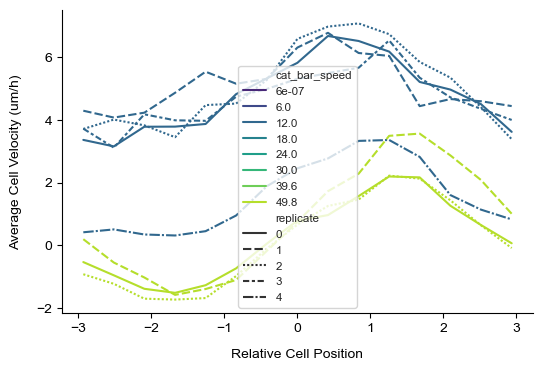

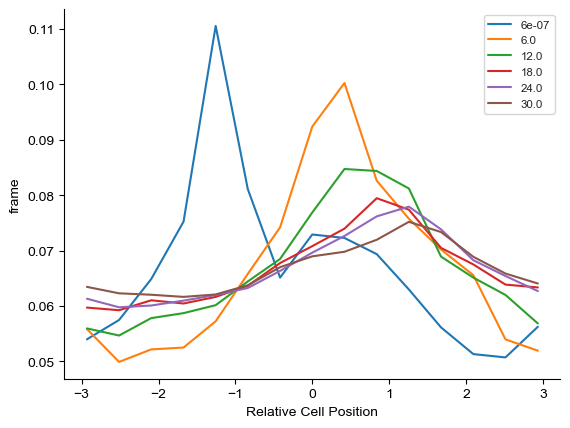

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])
all_dfs = pd.concat(subset_dfs, ignore_index=True)
all_dfs["Bar Speed (um/h)"] = all_dfs["speed"] * 60
all_dfs["cat_bar_speed"] = pd.Categorical(all_dfs["Bar Speed (um/h)"])
# all_dfs["Relative Cell Position"] = [-(p - 0.1) if p < 0.6 else -(p - 0.1) + 1.0 for p in all_dfs["phase"]]
# # all_dfs["Relative Cell Positions"]
# all_dfs["Relative Cell Position"] = pd.cut(all_dfs["Relative Cell Position"], bins=20)
# all_dfs["Relative Cell Position"] = [(p.right + p.left) / 2 for p in all_dfs["Relative Cell Position"]]
all_dfs["Average Cell Velocity (um/h)"] = all_dfs["um_y_per_min"] * 60
sns.lineplot(all_dfs[all_dfs["speed"].isin([0.2, 0.83])], x="Relative Cell Position", y="Average Cell Velocity (um/h)", hue="cat_bar_speed", errorbar=None, style="replicate", palette="viridis", legend=True)

ax.grid(False)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10

# plt.savefig(savepath / "phase_thing.pdf")
plt.show()
df = all_dfs[all_dfs["speed"] < 0.55]
for speed in df["speed"].unique():
    ss = df[df["speed"] == speed]
    sns.lineplot(ss.groupby("Relative Cell Position")["frame"].count() / len(ss["Relative Cell Position"]), label=speed*60)
plt.show()

   speed  replicate  Relative Cell Position       label        area  \
0    0.0          0               -2.931106  521.167433  315.505060   
1    0.0          0               -2.513274  516.052923  330.125504   
2    0.0          0               -2.095442  473.955728  326.316294   
3    0.0          0               -1.674469  473.229535  328.586771   
4    0.0          0               -1.256637  448.746800  336.850727   

         px_y        px_x      frame     tree_id    track_id  ...  dif_um_x  \
0  831.078574  764.810541  62.435603  798.085097  798.085097  ...  0.040057   
1  823.975622  799.880572  64.632560  866.183972  866.183972  ...  0.044009   
2  771.618582  824.968554  59.592880  888.934277  888.934277  ...  0.055639   
3  772.196114  800.619533  63.804191  834.922724  834.922724  ...  0.046667   
4  746.028667  774.965888  61.651985  741.732480  741.732480  ...  0.138177   

   um_x_per_min  um_x_per_h  parent_um_y  dif_um_y  um_y_per_min  um_y_per_h  \
0      0.008011   

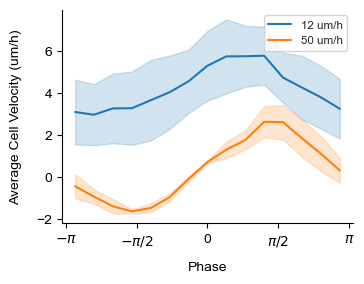

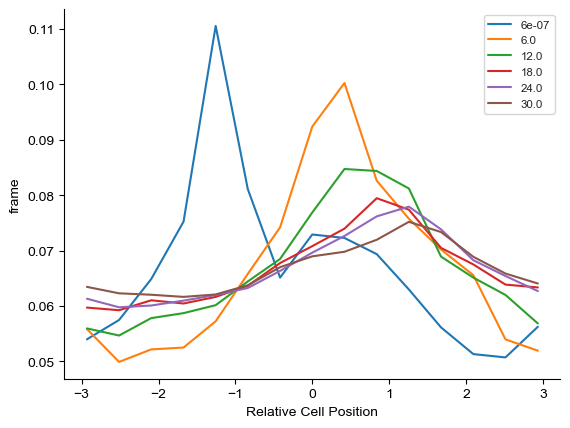

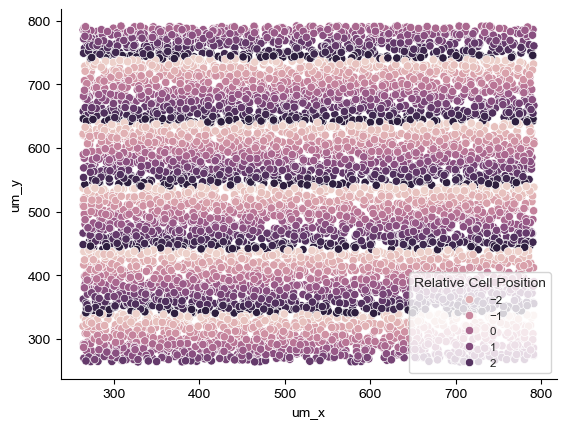

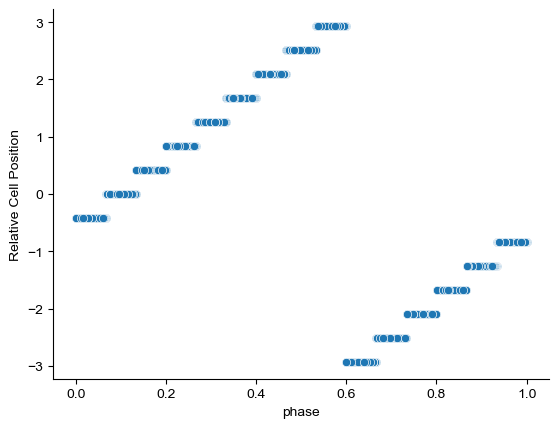

In [262]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
# fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.95])
all_dfs = pd.concat(subset_dfs, ignore_index=True)
all_dfs["Bar Speed (um/h)"] = all_dfs["speed"] * 60
# # all_dfs["cat_bar_speed"] = pd.Categorical(all_dfs["Bar Speed (um/h)"])
# all_dfs["Relative Cell Position"] = [-(p - 0.1) if p < 0.6 else -(p - 0.1) + 1.0 for p in all_dfs["phase"]]
# # all_dfs["Relative Cell Positions"]
# all_dfs["Relative Cell Position"] = pd.cut(all_dfs["Relative Cell Position"], bins=15)
# all_dfs["Relative Cell Position"] = [(p.right + p.left) / 2 for p in all_dfs["Relative Cell Position"]]
# all_dfs["Relative Cell Position"] = all_dfs["Relative Cell Position"] * -2*np.pi
all_dfs["Average Cell Velocity (um/h)"] = all_dfs["um_y_per_min"] * 60

t = all_dfs.groupby(["speed", "replicate", "Relative Cell Position"], as_index=False).mean()
t["speed"] =np.round(t["speed"], 2)
t["Bar Speed (um/h)"] =np.round(t["Bar Speed (um/h)"], 0)
# t["cat_bar_speed"] = pd.Categorical(t["Bar Speed (um/h)"])
print(t.head())
colors = ["C0", "C1"]
sns.lineplot(t[t["speed"].isin([0.20, 0.83])], x="Relative Cell Position", y="Average Cell Velocity (um/h)", hue="Bar Speed (um/h)", errorbar=("sd", 1), palette=colors, legend=False)

ax.grid(False)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
plt.xlabel("Phase")
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels=["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
labels=["12 um/h", "50 um/h"]
lines = []
for c, lab in zip(colors, labels):
    lines.append(Line2D([0, 0], [0, 0], color=c))

plt.legend(handles=lines, labels=labels)
plt.savefig(savepath / "phase_thing.pdf")
plt.show()
df = all_dfs[all_dfs["speed"] < 0.55]
for speed in df["speed"].unique():
    ss = df[df["speed"] == speed]
    sns.lineplot(ss.groupby("Relative Cell Position")["frame"].count() / len(ss["Relative Cell Position"]), label=speed*60)
plt.show()

frame = df["frame"].min()

ss = df[df["frame"] == frame]
sns.scatterplot(ss, x="um_x", y="um_y", hue="Relative Cell Position")
plt.show()

sns.scatterplot(ss, x="phase", y="Relative Cell Position")
plt.show()

0.08289645338856103
0.2


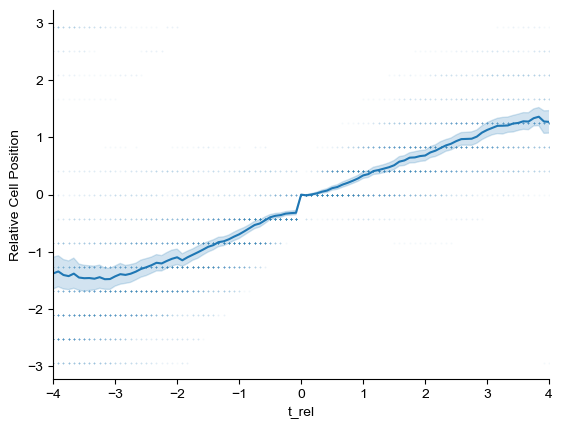

C:\Users\Harrison\AppData\Local\Temp\ipykernel_23496\2328298074.py:43: UserWarning: 
The palette list has fewer values (1) than needed (232) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=0.1, hue="track_id", legend=False, palette=[color])


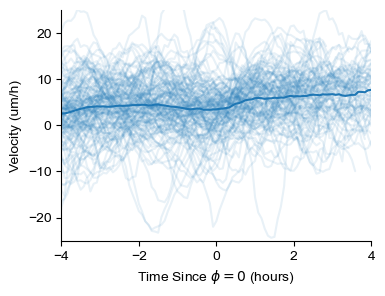

0.0019472461172805118
0.83


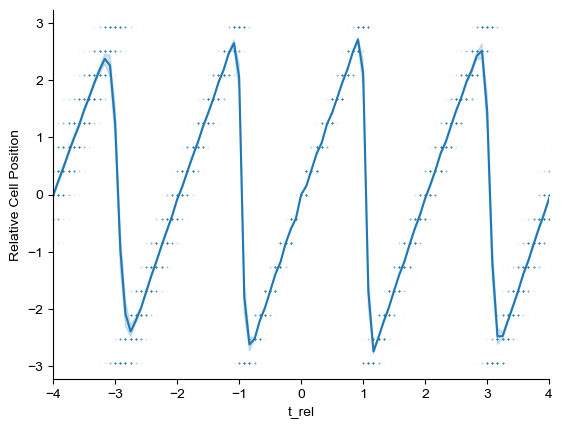

C:\Users\Harrison\AppData\Local\Temp\ipykernel_23496\2328298074.py:43: UserWarning: 
The palette list has fewer values (1) than needed (257) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=0.1, hue="track_id", legend=False, palette=[color])


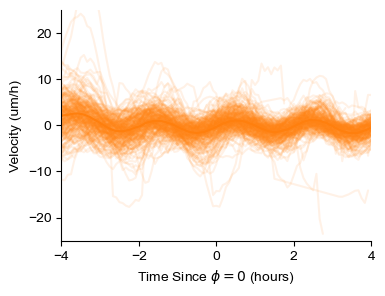

In [271]:
for n, color in zip([5, 25], ["C0", "C1"]):
    df2 = subset_dfs[n].copy()
    print(df2["um_y_per_min"].mean())
    print(df2["speed"].mean())
    speed = int(np.round(df2["speed"].mean()*60, 0))

    df2["track_start"] = df2["track_id"].map(df2.groupby("track_id")["t"].min())
    df2["track_end"] = df2["track_id"].map(df2.groupby("track_id")["t"].max())

    # print(df2["track_end"])

    df2 = df2[(df2["track_start"] < 30) & (df2["track_end"] > 60*7)].copy()

    df2["abs_phase"] = df2["Relative Cell Position"].abs()
    df2["track_min_phase"] = df2["track_id"].map(df2.groupby("track_id")["abs_phase"].min())
    df2 = df2[df2["track_min_phase"] == 0].copy()
    df2["is_zero"] = df2["Relative Cell Position"] == 0

    random_tracks = df2["track_id"].sample(500)
    df2 = df2[df2["track_id"].isin(random_tracks)]

    later_tps = df2[df2["t"] > 240].copy()

    later_tps["track_min_phase"] = later_tps["track_id"].map(later_tps.groupby("track_id")["abs_phase"].min())
    later_tps = later_tps[later_tps["track_min_phase"] == 0]

    t = df2["track_id"].map(later_tps.groupby("track_id")["is_zero"].idxmax().map(later_tps["t"]))
    y = df2["track_id"].map(later_tps.groupby("track_id")["is_zero"].idxmax().map(later_tps["um_y"]))

    df2["t_rel"] = (df2["t"] - t) / 60
    df2["y_rel"] = df2["um_y"] - y

    df2["y_smooth"] = df2.groupby("track_id").rolling(window=10, min_periods=1, center=True)["um_y_per_min"].mean().reset_index(level=0, drop=True)
    df2["Velocity (um/h)"] = df2["y_smooth"] * 60

    sns.scatterplot(df2, x="t_rel", y="Relative Cell Position", alpha=0.05, s=2.0)
    sns.lineplot(df2, x="t_rel", y="Relative Cell Position")
    plt.xlim(-4, 4)
    plt.show()


    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=0.1, hue="track_id", legend=False, palette=[color])
    sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=1, legend=False, color=color)

    plt.xlabel("Time Since $\phi=0$ (hours)")
    plt.xlim(-4, 4)
    plt.xticks([-4, -2, 0, 2, 4])
    plt.ylim(-25, 25)
    plt.savefig(savepath / f"{speed}umph_singlecelltracks_rollingmean.pdf")

    plt.show()



0.08289645338856103
0.2


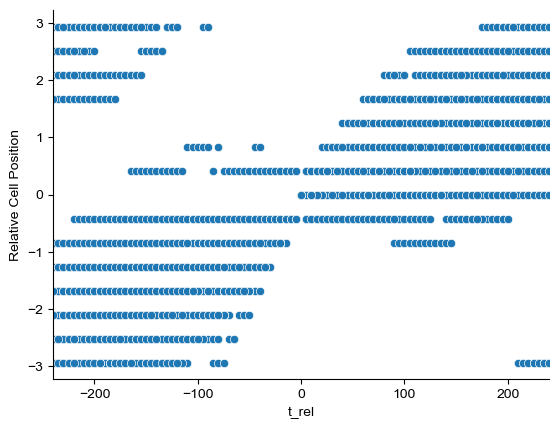

0.0019472461172805118
0.83
count    9948.000000
mean        0.008225
std         0.056628
min        -0.294007
25%        -0.022688
50%         0.003010
75%         0.031692
max         0.884087
Name: y_smooth, dtype: float64


C:\Users\Harrison\AppData\Local\Temp\ipykernel_23496\920823341.py:46: UserWarning: 
The palette list has fewer values (1) than needed (85) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=0.1, hue="track_id", legend=False, palette=["C1"])


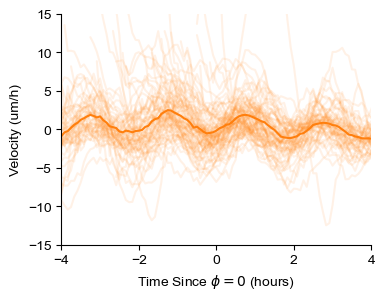

0.08890355655550716
0.20000000000000007
      track_id  level_1  um_y_per_min
0          167    14546           NaN
1          167    15507           NaN
2          167    16466           NaN
3          167    17426           NaN
4          167    18387      0.115251
...        ...      ...           ...
9675       998   118638      0.104255
9676       998   119831      0.112061
9677       998   121025      0.056536
9678       998   122222      0.053789
9679       998   123432      0.053603

[9680 rows x 3 columns]
count    9599.000000
mean        0.083332
std         0.105561
min        -0.738397
25%         0.019441
50%         0.084372
75%         0.150703
max         0.544110
Name: y_smooth, dtype: float64


C:\Users\Harrison\AppData\Local\Temp\ipykernel_23496\920823341.py:82: UserWarning: 
The palette list has fewer values (1) than needed (82) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=0.1, hue="track_id", legend=False, palette=["C0"])


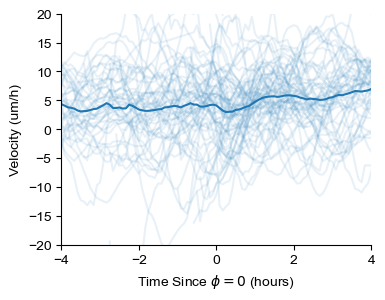

In [248]:
df = subset_dfs[5].copy()
print(df["um_y_per_min"].mean())
print(df["speed"].mean())
df["abs_phase"] = df["Relative Cell Position"].abs()
df["track_min_phase"] = df["track_id"].map(df.groupby("track_id")["abs_phase"].min())
df["track_n_spots"] = df["track_id"].map(df.groupby("track_id")["frame"].count())
df = df[df["track_n_spots"] > 100].copy()
df = df[df["track_min_phase"] == 0].copy()
random_tracks = df["track_id"].sample(500)
df = df[df["track_id"].isin(random_tracks)]
t = df["track_id"].map(df.groupby("track_id")["abs_phase"].idxmin().map(df["t"]))
y = df["track_id"].map(df.groupby("track_id")["abs_phase"].idxmin().map(df["um_y"]))

df["t_rel"] = df["t"] - t
df["y_rel"] = df["um_y"] - y



sns.scatterplot(df, x="t_rel", y="Relative Cell Position")
plt.xlim(-240, 240)
plt.show()

df2 = subset_dfs[25].copy()
print(df2["um_y_per_min"].mean())
print(df2["speed"].mean())
df2["abs_phase"] = (df2["phase"] - 0.1).abs()
df2["track_n_spots"] = df2["track_id"].map(df2.groupby("track_id")["frame"].count())
df2 = df2[df2["track_n_spots"] > 100].copy()
random_tracks = df2["track_id"].sample(100)
df2 = df2[df2["track_id"].isin(random_tracks)]
t = df2["track_id"].map(df2.groupby("track_id")["abs_phase"].idxmin().map(df2["t"]))
y = df2["track_id"].map(df2.groupby("track_id")["abs_phase"].idxmin().map(df2["um_y"]))

df2["t_rel"] = (df2["t"] - t) / 60
df2["y_rel"] = df2["um_y"] - y

df2["y_smooth"] = df2.groupby("track_id").rolling(window=10, min_periods=1)["um_y_per_min"].mean().reset_index(level=0, drop=True)
print(df2["y_smooth"].describe())

df2["Velocity (um/h)"] = df2["y_smooth"] * 60

# df3 = pd.concat([df, df2])

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=0.1, hue="track_id", legend=False, palette=["C1"])
sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=1, legend=False, color="C1")

plt.xlabel("Time Since $\phi=0$ (hours)")


plt.xlim(-4, 4)
plt.xticks([-4, -2, 0, 2, 4])
plt.ylim(-15, 15)
plt.savefig(savepath / "50umph_singlecelltracks_rollingmean.pdf")

plt.show()

df2 = subset_dfs[7].copy()
print(df2["um_y_per_min"].mean())
print(df2["speed"].mean())
df2["abs_phase"] = (df2["phase"] - 0.1).abs()
df2["track_n_spots"] = df2["track_id"].map(df2.groupby("track_id")["frame"].count())
df2 = df2[df2["track_n_spots"] > 100].copy()
random_tracks = df2["track_id"].sample(100)
df2 = df2[df2["track_id"].isin(random_tracks)]
t = df2["track_id"].map(df2.groupby("track_id")["abs_phase"].idxmin().map(df2["t"]))
y = df2["track_id"].map(df2.groupby("track_id")["abs_phase"].idxmin().map(df2["um_y"]))

df2["t_rel"] = (df2["t"] - t) / 60
df2["y_rel"] = df2["um_y"] - y
print(df2.groupby("track_id").rolling(5)["um_y_per_min"].mean().reset_index())
df2["y_smooth"] = df2.groupby("track_id").rolling(window=10, min_periods=1)["um_y_per_min"].mean().reset_index(level=0, drop=True)
print(df2["y_smooth"].describe())

df2["Velocity (um/h)"] = df2["y_smooth"] * 60

# df3 = pd.concat([df, df2])

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=0.1, hue="track_id", legend=False, palette=["C0"])
sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=1, legend=False, color="C0")

plt.xlabel("Time Since $\phi=0$ (hours)")


plt.xlim(-4, 4)
plt.xticks([-4, -2, 0, 2, 4])
plt.ylim(-20, 20)
plt.savefig(savepath / "12umph_singlecelltracks_rollingmean.pdf")
plt.show()


0.0019472461172805118
0.83
count    10200.000000
mean         0.007295
std          0.052093
min         -0.251923
25%         -0.022547
50%          0.001959
75%          0.031705
max          0.417465
Name: y_smooth, dtype: float64


C:\Users\Harrison\AppData\Local\Temp\ipykernel_23496\4125670866.py:24: UserWarning: 
The palette list has fewer values (1) than needed (87) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=0.1, hue="track_id", legend=False, palette=["C1"])


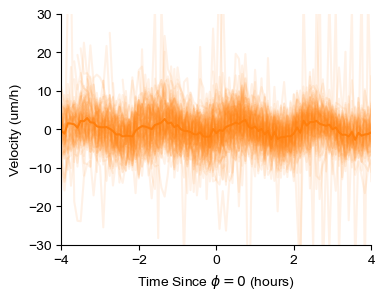

0.08890355655550716
0.20000000000000007
      track_id  level_1  um_y_per_min
0          167    14546           NaN
1          167    15507           NaN
2          167    16466           NaN
3          167    17426           NaN
4          167    18387      0.115251
...        ...      ...           ...
9114       711    98567      0.021795
9115       711    99680      0.004632
9116       711   100798      0.012545
9117       711   101923      0.018598
9118       711   103030      0.023720

[9119 rows x 3 columns]
count    9043.000000
mean        0.084381
std         0.100902
min        -0.378020
25%         0.023906
50%         0.088402
75%         0.149513
max         0.441038
Name: y_smooth, dtype: float64


C:\Users\Harrison\AppData\Local\Temp\ipykernel_23496\4125670866.py:60: UserWarning: 
The palette list has fewer values (1) than needed (77) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=0.1, hue="track_id", legend=False, palette=["C0"])


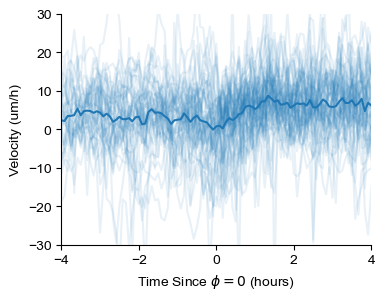

In [221]:
df2 = subset_dfs[25].copy()
print(df2["um_y_per_min"].mean())
print(df2["speed"].mean())
df2["abs_phase"] = df2["phase"].abs()
df2["track_n_spots"] = df2["track_id"].map(df2.groupby("track_id")["frame"].count())
df2 = df2[df2["track_n_spots"] > 100].copy()
random_tracks = df2["track_id"].sample(100)
df2 = df2[df2["track_id"].isin(random_tracks)]
t = df2["track_id"].map(df2.groupby("track_id")["abs_phase"].idxmin().map(df2["t"]))
y = df2["track_id"].map(df2.groupby("track_id")["abs_phase"].idxmin().map(df2["um_y"]))

df2["t_rel"] = (df2["t"] - t) / 60
df2["y_rel"] = df2["um_y"] - y

df2["y_smooth"] = df2.groupby("track_id").rolling(window=10, min_periods=1)["um_y_per_min"].mean().reset_index(level=0, drop=True)
print(df2["y_smooth"].describe())

df2["Velocity (um/h)"] = df2["um_y_per_min"] * 60

# df3 = pd.concat([df, df2])

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=0.1, hue="track_id", legend=False, palette=["C1"])
sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=1, legend=False, color="C1")

plt.xlabel("Time Since $\phi=0$ (hours)")


plt.xlim(-4, 4)
plt.xticks([-4, -2, 0, 2, 4])
plt.ylim(-30, 30)
plt.savefig(savepath / "50umph_singlecelltracks.pdf")

plt.show()

df2 = subset_dfs[7].copy()
print(df2["um_y_per_min"].mean())
print(df2["speed"].mean())
df2["abs_phase"] = df2["phase"].abs()
df2["track_n_spots"] = df2["track_id"].map(df2.groupby("track_id")["frame"].count())
df2 = df2[df2["track_n_spots"] > 100].copy()
random_tracks = df2["track_id"].sample(100)
df2 = df2[df2["track_id"].isin(random_tracks)]
t = df2["track_id"].map(df2.groupby("track_id")["abs_phase"].idxmin().map(df2["t"]))
y = df2["track_id"].map(df2.groupby("track_id")["abs_phase"].idxmin().map(df2["um_y"]))

df2["t_rel"] = (df2["t"] - t) / 60
df2["y_rel"] = df2["um_y"] - y
print(df2.groupby("track_id").rolling(5)["um_y_per_min"].mean().reset_index())
df2["y_smooth"] = df2.groupby("track_id").rolling(window=10, min_periods=1)["um_y_per_min"].mean().reset_index(level=0, drop=True)
print(df2["y_smooth"].describe())

df2["Velocity (um/h)"] = df2["um_y_per_min"] * 60

# df3 = pd.concat([df, df2])

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=0.1, hue="track_id", legend=False, palette=["C0"])
sns.lineplot(df2, x="t_rel", y="Velocity (um/h)", errorbar=None, alpha=1, legend=False, color="C0")

plt.xlabel("Time Since $\phi=0$ (hours)")


plt.xlim(-4, 4)
plt.xticks([-4, -2, 0, 2, 4])
plt.ylim(-30, 30)
plt.savefig(savepath / "12umph_singlecelltracks.pdf")
plt.show()

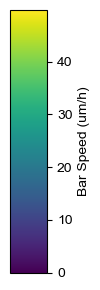

In [91]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Create a colormap and a normalization object
cmap = cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=all_dfs["Bar Speed (um/h)"].max()) # Define the data range for the colorbar

# Create a ScalarMappable object
s_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
s_mappable.set_array([]) # Important: set an empty array for the mappable

# Create a figure and an axes for the colorbar
fig, ax = plt.subplots(figsize=(1.1, 3)) # Adjust figsize for desired colorbar dimensions

# Draw the colorbar
cbar = fig.colorbar(s_mappable, cax=ax)
cbar.set_label('Bar Speed (um/h)')
plt.tight_layout()
plt.savefig(savepath / "barspeed_cbar.pdf")
plt.show()

count    23645.000000
mean        69.243265
std         10.223485
min          1.000000
25%         72.000000
50%         72.000000
75%         72.000000
max         72.000000
Name: track_length, dtype: float64
count    56091.000000
mean        69.231766
std          9.719561
min          1.000000
25%         72.000000
50%         72.000000
75%         72.000000
max         72.000000
Name: track_length, dtype: float64
count    36273.000000
mean        68.696468
std         11.139321
min          1.000000
25%         72.000000
50%         72.000000
75%         72.000000
max         72.000000
Name: track_length, dtype: float64
count    49717.000000
mean        69.973872
std          8.599890
min          1.000000
25%         72.000000
50%         72.000000
75%         72.000000
max         72.000000
Name: track_length, dtype: float64
count    26761.000000
mean        68.586637
std         10.944464
min          1.000000
25%         72.000000
50%         72.000000
75%         72.000000
ma

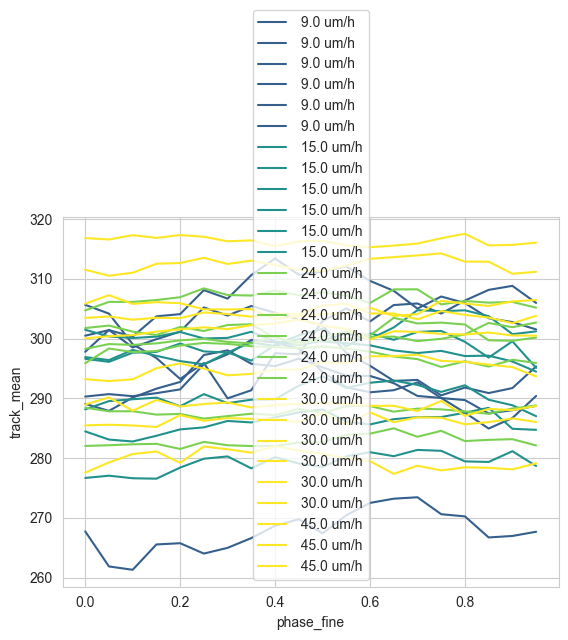

In [6]:
fig, ax = plt.subplots(1, 1)

for df, bar_speed in zip(subset_dfs, barspeeds):
# df = subset_dfs[1]
    df["track_length"] = df["track_id"].map(df.groupby("track_id")["frame"].count())
    print(df["track_length"].describe())

    df["track_mean"] = df["track_id"].map(df.groupby("track_id")["intensity_mean"].mean())
    df["track_std"] = df["track_id"].map(df.groupby("track_id")["intensity_mean"].std())
    df["track_zscore"] = (df["intensity_mean"] - df["track_mean"]) / df["track_std"]

    df["phase_fine"] = (df["phase"] // 0.05) * 0.05

    # sns.scatterplot(df, x="phase", y="track_zscore", alpha=0.25, s=5)
    sns.lineplot(df, x="phase_fine", y="track_mean", errorbar=None, color=pal(bar_speed*2),
                    label=f"{bar_speed * 60: 0.1f} um/h")
# plt.ylim([-2, 2])

plt.show()


Index(['bar_speed', 'avg_speed', 'median_speed', 'top_speed', 'n_cells',
       'avg_speed_any', 'batch', 'replicate', 'bar_speed_h', 'avg_speed_h',
       'any_speed_h'],
      dtype='object')


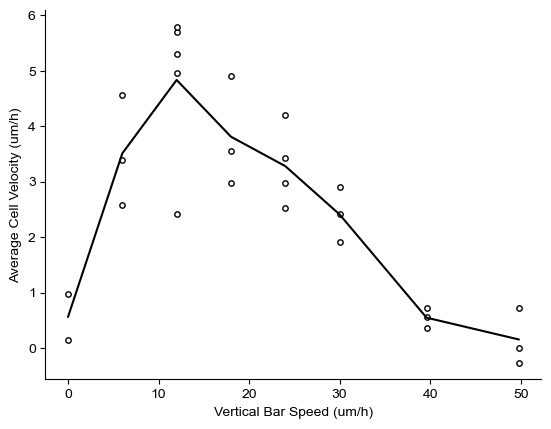

In [56]:
experiments_df = pd.DataFrame(experiments)
experiments_df["bar_speed_h"] = experiments_df["bar_speed"] * 60
experiments_df["avg_speed_h"] = experiments_df["avg_speed"] * 60
experiments_df["any_speed_h"] = experiments_df["avg_speed_any"] * 60
# experiments_df[""]


experiments_df["batch"] = pd.Categorical(experiments_df["batch"])

print(experiments_df.columns)

sns.scatterplot(data=experiments_df, x="bar_speed_h", y="avg_speed_h", color="white", edgecolor="k", linewidth=1.0, s=15)
sns.lineplot(data=experiments_df, x="bar_speed_h", y="avg_speed_h", errorbar=None, color="k")

plt.xlabel("Vertical Bar Speed (um/h)")
plt.ylabel("Average Cell Velocity (um/h)")
plt.savefig(savepath / "barspeeds.pdf")
plt.show()

2122it [00:07, 269.61it/s]


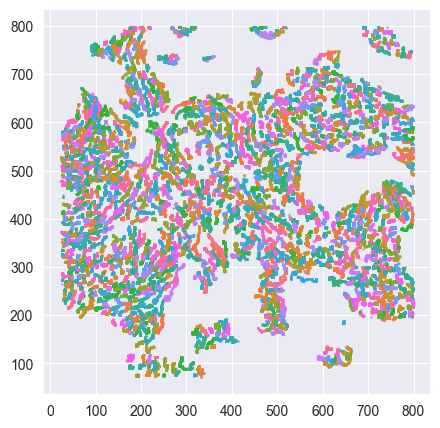

In [18]:

pal = sns.color_palette("husl", n_colors=20)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.set_xlim(500, 1000)
# ax.set_ylim(500, 1000)

subset = spots_df[spots_df["px_x"].between(0, 800) & spots_df["px_y"].between(0, 800)].copy()

for i, track_id in tqdm(enumerate(subset["track_id"].unique())):
    x, y = subset[subset["track_id"] == track_id][["px_x", "px_y"]].values.T

    ax.scatter(x, y, s=1, color=pal[i % 20], alpha=0.5)

plt.show()

In [4]:
# edge_map = {child: parent for parent, child in graph.edges()}
spots_df["parent"] = spots_df.index.map(edge_map)
spots_df["x"] = spots_df["POSITION_X"] * 0.66
spots_df["y"] = spots_df["POSITION_Y"] * 0.66
spots_df["t"] = spots_df["FRAME"] * 5
parents = edge_map.values()

X = spots_df.loc[parents, ["t", "x", "y"]]

spots_df["parent_t"] = spots_df["parent"].map(X["t"])
spots_df["parent_x"] = spots_df["parent"].map(X["x"])
spots_df["parent_y"] = spots_df["parent"].map(X["y"])

spots_df["dx"] = (spots_df["x"] - spots_df["parent_x"]) / (spots_df["t"] - spots_df["parent_t"])
spots_df["dy"] = (spots_df["y"] - spots_df["parent_y"]) / (spots_df["t"] - spots_df["parent_t"])

bar_speed = 1.0
period = 100
period_time = period / bar_speed
duty_cycle = 0.2

spots_df["phase"] = ((spots_df["t"] - (spots_df["y"] / bar_speed)) % period_time) / period_time



In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

subset = spots_df[
    (spots_df["x"] > spots_df["x"].quantile(0.25)) &
    (spots_df["x"] < spots_df["x"].quantile(0.75)) &
    (spots_df["y"] > spots_df["y"].quantile(0.25)) &
    (spots_df["y"] < spots_df["y"].quantile(0.75))
].copy()

subset["hour"] = subset["t"] // 60
subset["phase_group"] = subset["phase"] // 0.05

sns.lineplot(data=subset, x="hour", y="dy", hue="phase_group", palette="tab10")
plt.show()

KeyError: 'x'

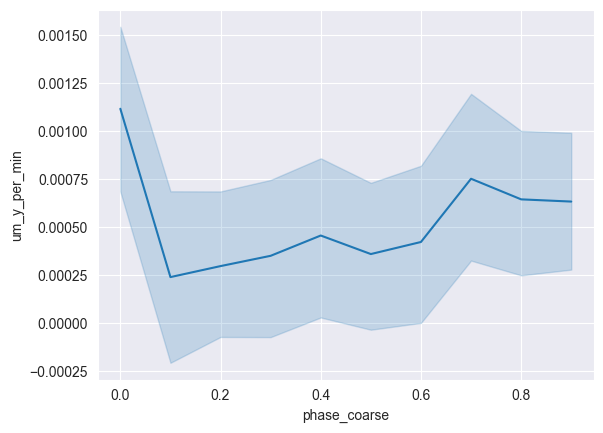

In [16]:
sns.lineplot(data=subset, x="phase_coarse", y="um_y_per_min", )
plt.show()

In [4]:
def process_trackmate_tree(tree: ET) -> (pd.DataFrame, DiGraph):
    """
    Process trackmate tree
    :param tree: ElementTree object from trackmate xml file
    :return:
    """

    graph = DiGraph()
    root = tree.getroot()

    # iterate through spot elements and collect attributes
    spots = root.find("Model").find("AllSpots")
    spots_collect = []

    for spot_frame in tqdm(spots, desc="parsing spots; frame"):
        for spot in spot_frame:
            # spot id is always an int
            spot_id = int(spot.get("ID"))
            graph.add_node(spot_id)

            # get all attributes and convert to floats
            spot_attributes = spot.attrib
            spot_attributes = {key: float(value) for key, value in spot_attributes.items() if key != "name"}

            spot_attributes["graph_key"] = spot_id
            spot_attributes["FRAME"] = int(spot_attributes["FRAME"])

            # mostly used in 2d
            if spot.text:
                spot_attributes["roi"] = [float(pt) for pt in spot.text.split(" ")]

            spots_collect.append(spot_attributes)

    # use graph key universally as an index
    spots_df = pd.DataFrame(spots_collect, index=[c["graph_key"] for c in spots_collect])
    assert np.all(spots_df.index == spots_df["ID"])

    # iterate through track elements to construct graph and assign trackid
    tracks = root.find("Model").find("AllTracks")

    for i, track in enumerate(tqdm(tracks, desc="parsing edges; track"), start=1):
        track_id = i

        this_track_spots = set()

        for edge in track:
            edge_attributes = edge.attrib

            source_spot_id = int(edge_attributes["SPOT_SOURCE_ID"])
            target_spot_id = int(edge_attributes["SPOT_TARGET_ID"])

            this_track_spots.add(source_spot_id)
            this_track_spots.add(target_spot_id)

        this_track_spots = list(this_track_spots)

        track_spots = spots_df.loc[this_track_spots].sort_values(by=["FRAME"]).index
        for source, target in zip(track_spots[:-1], track_spots[1:]):
            source_spot_frame = int(spots_df.loc[source]["FRAME"])
            target_spot_frame = int(spots_df.loc[target]["FRAME"])

            # add edge to graph
            graph.add_edge(source, target, track_id=track_id, time=target_spot_frame - source_spot_frame)

        spots_df.loc[this_track_spots, "linear_track_id"] = track_id

    print(f"track id 0 corresponds to {np.sum(spots_df['linear_track_id'].isna())} edgeless spots")

    return spots_df, graph


# tree = ET.parse(r"D:\FeedbackControl\data\results\bar05.07_tracks.xml")
#
# spots_df, graph = process_trackmate_tree(tree)

In [9]:
sources = {
    "0.5": r"D:\FeedbackControl\data\results\bar05.07_tracks.xml",
    "1.0": r"D:\FeedbackControl\data\results\bar1.00_cpmasks.xml",
}

dfs = {}

for speed, source in sources.items():
    tree = ET.parse(source)
    spots_df, graph = process_trackmate_tree(tree)
    edge_map = {child: parent for parent, child in graph.edges()}
    spots_df["parent"] = spots_df.index.map(edge_map)
    spots_df["x"] = spots_df["POSITION_X"] * 0.66
    spots_df["y"] = spots_df["POSITION_Y"] * 0.66
    spots_df["t"] = spots_df["FRAME"] * 5
    parents = edge_map.values()

    X = spots_df.loc[parents, ["t", "x", "y"]]

    spots_df["parent_t"] = spots_df["parent"].map(X["t"])
    spots_df["parent_x"] = spots_df["parent"].map(X["x"])
    spots_df["parent_y"] = spots_df["parent"].map(X["y"])

    spots_df["dx"] = (spots_df["x"] - spots_df["parent_x"]) / (spots_df["t"] - spots_df["parent_t"])
    spots_df["dy"] = (spots_df["y"] - spots_df["parent_y"]) / (spots_df["t"] - spots_df["parent_t"])

    bar_speed = float(speed)
    period = 100
    period_time = period / bar_speed
    duty_cycle = 0.2

    spots_df["phase"] = ((spots_df["t"] - (spots_df["y"] / bar_speed)) % period_time) / period_time

    dfs[speed] = spots_df




FileNotFoundError: [Errno 2] No such file or directory: 'D:\\FeedbackControl\\data\\results\\bar05.07_tracks.xml'

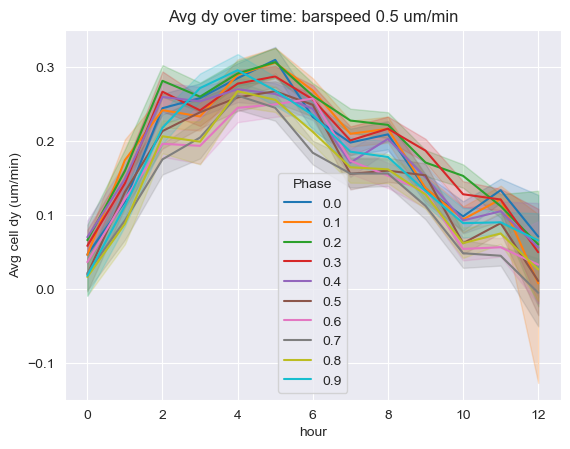

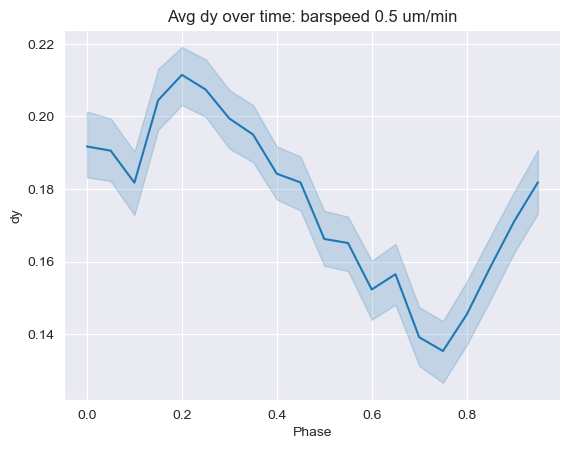

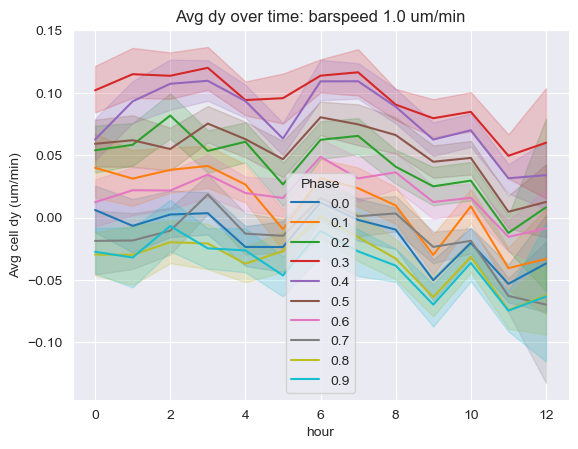

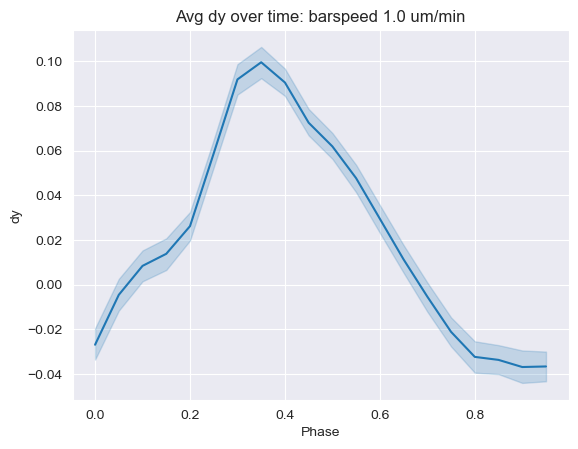

In [6]:
for speed, spots_df in dfs.items():

    subset = spots_df[
        (spots_df["x"] > spots_df["x"].quantile(0.25)) &
        (spots_df["x"] < spots_df["x"].quantile(0.75)) &
        (spots_df["y"] > spots_df["y"].quantile(0.25)) &
        (spots_df["y"] < spots_df["y"].quantile(0.75))
        ].copy()

    subset["hour"] = subset["t"] // 60
    subset["phase_group_fine"] = (subset["phase"] // 0.05) * 0.05
    subset["phase_group_broad"] = (subset["phase"] // 0.1) * 0.1

    sns.lineplot(data=subset, x="hour", y="dy", hue="phase_group_broad", palette="tab10")
    plt.title(f"Avg dy over time: barspeed {speed} um/min")

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [label[:3] for label in labels]
    ax.legend(handles, new_labels, title = 'Phase')

    plt.ylabel("Avg cell dy (um/min)")
    plt.show()

    sns.lineplot(data=subset, x="phase_group_fine", y="dy", )
    plt.title(f"Avg dy over time: barspeed {speed} um/min")
    plt.xlabel("Phase")
    plt.show()

In [9]:
import napari

cmap = plt.get_cmap("PiYG")

viewer = napari.Viewer()

df = dfs["1.0"]

df = df[~df["dy"].isna()]

X = df[["FRAME", "x", "y"]].values
y = df["dy"].values

cmax = max(np.abs(np.quantile(y, 0.99)), np.abs(np.quantile(y, 0.01)))
cmin = -cmax

print(cmax)

color = cmap(np.clip(y, cmin, cmax) - cmin / (cmax - cmin))

scatter = viewer.add_points(X, size=25, face_color=color, name="dy", border_color="black")

napari.run()

0.46156648605629186


In [ ]:
color

# bounce

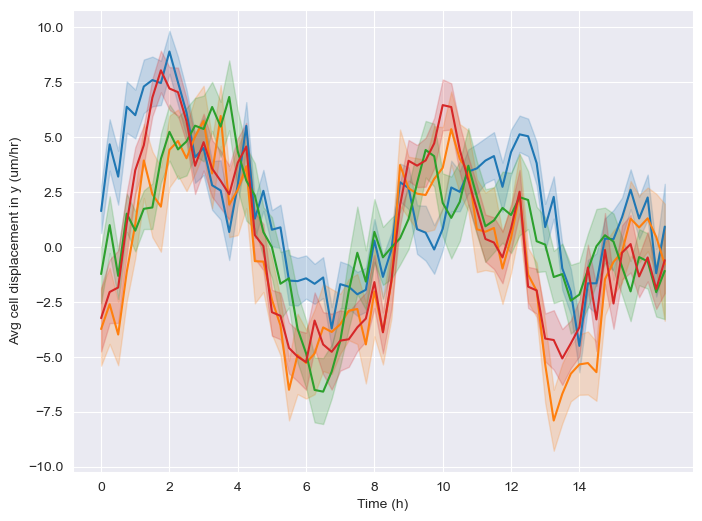

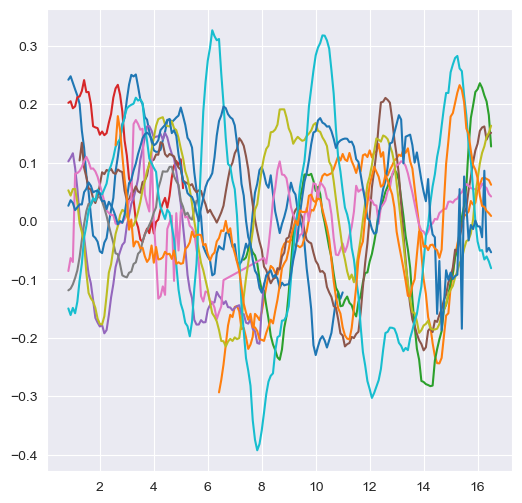